In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchtnt.utils.device import copy_data_to_device
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10, CIFAR100, MNIST, FashionMNIST
from torcheval.metrics import MulticlassAccuracy
from tqdm.auto import tqdm

from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

jet = cm.get_cmap('jet')

from resnet import *
from convnet import *
from dataset import *

device = torch.device("cuda:1")

/tmp/ipykernel_54465/873241153.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


In [3]:
def collate_fn(batch) -> Batch:
    labels = torch.stack([b[1] for b in batch], dim=0)
    images = torch.stack([b[0] for b in batch], dim=0)
    return Batch(images=images, labels=labels)

train_set = FashionMNIST(
    root="../FashionMNIST",
    train=True,
    download=True,
    target_transform=lambda i : F.one_hot(torch.tensor(i), num_classes=10),
    transform=FashionMNISTTransform("train"))

val_set = FashionMNIST(
    root="../FashionMNIST",
    train=False,
    download=True,
    target_transform=lambda i : F.one_hot(torch.tensor(i), num_classes=10),
    transform=FashionMNISTTransform("val"))

train_set_lower = torch.utils.data.Subset(train_set, torch.where(torch.tensor(train_set.targets) < 5)[0])
train_set_upper = torch.utils.data.Subset(train_set, torch.where(torch.tensor(train_set.targets) >= 5)[0])
val_set_lower = torch.utils.data.Subset(val_set, torch.where(torch.tensor(val_set.targets) < 5)[0])
val_set_upper = torch.utils.data.Subset(val_set, torch.where(torch.tensor(val_set.targets) >= 5)[0])

train_loader_upper = DataLoader(
    train_set_upper,
    batch_size=512,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    collate_fn=collate_fn,
)
train_loader_lower = DataLoader(
    train_set_lower,
    batch_size=512,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    collate_fn=collate_fn,
)
val_loader_upper = DataLoader(
    val_set_upper,
    batch_size=512,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    collate_fn=collate_fn,
)
val_loader_lower = DataLoader(
    val_set_lower,
    batch_size=512,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    collate_fn=collate_fn,
)

/tmp/ipykernel_54465/174709591.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set_lower = torch.utils.data.Subset(train_set, torch.where(torch.tensor(train_set.targets) < 5)[0])
/tmp/ipykernel_54465/174709591.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set_upper = torch.utils.data.Subset(train_set, torch.where(torch.tensor(train_set.targets) >= 5)[0])
/tmp/ipykernel_54465/174709591.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_set_lower = torch.utils.data.Subset(val_set, torch.where(torch.tensor(val_s

In [ ]:
module = resnet18(in_dim=3, out_dim=10, activation=torch.nn.functional.leaky_relu)
#module = ConvNet(in_dim=1, out_dim=10, activation=torch.nn.functional.leaky_relu)
module = module.to(device)

max_epochs = 50

optimizer = optim.SGD(
    module.parameters(),
    lr=0.01,
)

lr_scheduler = CosineAnnealingLR(optimizer, T_max=200)
#lr_scheduler = StepLR(optimizer, 1, 0.7)

lower_acc = MulticlassAccuracy()
upper_acc = MulticlassAccuracy()
tracker = {"lower_acc" : [], "upper_acc" : []}

for epoch in range(max_epochs * 2):
    print(f"Epoch {epoch}", end=" ")
    module.train()
    if epoch < max_epochs: 
        train_loader = train_loader_lower
    else:
        train_loader = train_loader_upper

    for batch in train_loader:
        optimizer.zero_grad()
        batch = copy_data_to_device(batch, device=device)
        logits = module(batch.images)
        loss = F.cross_entropy(logits,
                               torch.argmax(batch.labels, dim=-1))
        loss.backward()
        optimizer.step()
    #lr_scheduler.step()
    
    module.eval()
    for batch in val_loader_lower:
        batch = copy_data_to_device(batch, device=device)
        logits = module(batch.images)
        pred_idx = torch.argmax(logits, dim=-1)
        target_idx = torch.argmax(batch.labels, dim=-1)
        lower_acc.update(pred_idx, target_idx)
    for batch in val_loader_upper:
        batch = copy_data_to_device(batch, device=device)
        logits = module(batch.images)
        pred_idx = torch.argmax(logits, dim=-1)
        target_idx = torch.argmax(batch.labels, dim=-1)
        upper_acc.update(pred_idx, target_idx)
    print(f"VAL-ACC lower: {lower_acc.compute()}", end=" ")
    print(f"VAL-ACC upper: {upper_acc.compute()}", end=" ")
    print(f"| lr = {lr_scheduler.get_last_lr()[0]}")
    tracker["lower_acc"].append(torch.nan_to_num(lower_acc.compute(), 0.0))
    tracker["upper_acc"].append(torch.nan_to_num(upper_acc.compute(), 0.0))
    lower_acc.reset()
    upper_acc.reset()

In [ ]:
fig = plt.figure()
plt.plot(tracker["lower_acc"], label="lower")
plt.plot(tracker["upper_acc"], label="upper")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Ours

In [32]:
from model import Model
module = Model(
        dim_in=1,
        dim_out=10,
        backbone="convnet",
        activation=torch.nn.functional.leaky_relu,
        alpha=0.98,
        beta=0.05,
        kernel="linear",
        device=device,
    ).to(device)

def evaluate(val_loader, module, minterms, minterm_evecs, metric):
    module.eval()
    for batch in val_loader:
        batch_size = batch.labels.shape[0]
        batch = copy_data_to_device(batch, device=device)
        minterm_labels = torch.full((batch_size,), -1.0, device=device)
        for i, minterm in enumerate(minterms):
            mask = (batch.labels == minterm).all(dim=-1)
            minterm_labels.masked_fill_(mask, i)

        x_query, _ = module.embed(batch)
        x_query = F.normalize(x_query, dim=-1, p=2)
        p = torch.square(x_query @ minterm_evecs.T)
        p = p / p.sum(-1, keepdim=True)
        minterm_predictions = torch.argmax(p, dim=-1)

        metric.update(minterm_predictions[minterm_labels > -1], minterm_labels[minterm_labels > -1])

In [33]:
max_epochs = 60
optimizer = optim.SGD(module.parameters(), lr=0.0002)
lr_scheduler = StepLR(optimizer, 30, 0.5)

lower_acc = MulticlassAccuracy()
upper_acc = MulticlassAccuracy()
tracker = {"lower_acc" : [], "upper_acc" : []}

for epoch in range(max_epochs * 2 + 10):
    print(f"Epoch {epoch}", end=" ")
    module.train()
    module.forget()

    if epoch < max_epochs: 
        train_loader = train_loader_lower
    else:
        train_loader = train_loader_upper

    for batch in train_loader:
        optimizer.zero_grad()
        batch = copy_data_to_device(batch, device=device)
        embeddings, _ = module.embed(batch)

        if epoch < max_epochs:
            y = batch.labels.float().T
            x = embeddings.T
            z = torch.cat((y, x), dim=0)
        else:
            _,_,vh = torch.linalg.svd(lower_evecs)
            complement = vh[5:,:]

            y = batch.labels.float().T
            x_in = torch.sqrt((complement @ embeddings.T).sum(0, keepdim=True))
            x_out = lower_evecs @ embeddings.T
            x = torch.cat((x_in, x_out), dim=0)
            z = torch.cat((y, x), dim=0)

        module.remember(embeddings.detach(), batch)

        z_svals = torch.linalg.svdvals(z)
        x_svals = torch.linalg.svdvals(x)
        loss = z_svals.sum()
        loss -= module._alpha * x_svals.sum()
        loss += module._beta * x_svals.max() ** 2
        loss.backward()

        optimizer.step()
    lr_scheduler.step()
    
    module.update_minterms()

    if epoch < max_epochs:
        lower_minterms = module._minterms
        lower_evecs = torch.cat(module._minterm_evecs, dim=0)
        upper_minterms = None
        upper_evecs = None
    else:    
        upper_minterms = module._minterms
        upper_evecs = torch.cat(module._minterm_evecs, dim=0)

    if lower_minterms is not None:
        evaluate(val_loader_lower, module, lower_minterms, lower_evecs, lower_acc)
    if upper_minterms is not None:
        evaluate(val_loader_upper, module, upper_minterms, upper_evecs, upper_acc)

    print(f"VAL-ACC lower: {lower_acc.compute()}", end=" ")
    print(f"VAL-ACC upper: {upper_acc.compute()}", end=" ")
    print(f"| lr = {lr_scheduler.get_last_lr()[0]}")
    tracker["lower_acc"].append(torch.nan_to_num(lower_acc.compute(), 0.0))
    tracker["upper_acc"].append(torch.nan_to_num(upper_acc.compute(), 0.0))
    lower_acc.reset()
    upper_acc.reset()

Epoch 0 VAL-ACC lower: 0.673799991607666 VAL-ACC upper: nan | lr = 0.0002
Epoch 1 VAL-ACC lower: 0.7454000115394592 VAL-ACC upper: nan | lr = 0.0002
Epoch 2 VAL-ACC lower: 0.7706000208854675 VAL-ACC upper: nan | lr = 0.0002
Epoch 3 VAL-ACC lower: 0.8023999929428101 VAL-ACC upper: nan | lr = 0.0002
Epoch 4 VAL-ACC lower: 0.8145999908447266 VAL-ACC upper: nan | lr = 0.0002
Epoch 5 VAL-ACC lower: 0.8101999759674072 VAL-ACC upper: nan | lr = 0.0002
Epoch 6 VAL-ACC lower: 0.8087999820709229 VAL-ACC upper: nan | lr = 0.0002
Epoch 7 VAL-ACC lower: 0.8087999820709229 VAL-ACC upper: nan | lr = 0.0002
Epoch 8 VAL-ACC lower: 0.8118000030517578 VAL-ACC upper: nan | lr = 0.0002
Epoch 9 VAL-ACC lower: 0.8159999847412109 VAL-ACC upper: nan | lr = 0.0002
Epoch 10 VAL-ACC lower: 0.8227999806404114 VAL-ACC upper: nan | lr = 0.0002
Epoch 11 VAL-ACC lower: 0.8277999758720398 VAL-ACC upper: nan | lr = 0.0002
Epoch 12 VAL-ACC lower: 0.8312000036239624 VAL-ACC upper: nan | lr = 0.0002
Epoch 13 VAL-ACC lower:

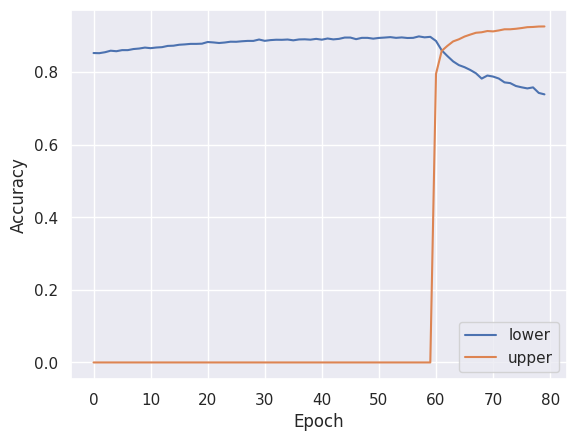

In [31]:
fig = plt.figure()
plt.plot(tracker["lower_acc"], label="lower")
plt.plot(tracker["upper_acc"], label="upper")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
#fig.savefig("hmm.png")

In [ ]:
lower_evecs @ lower_evecs.T